In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src.cluster.cluster import *
import os
from src.test.evaluate import *
from src.test.display_npy import *
from src.helper_functions import *
from src.data.preprocess import *


In [7]:
import numpy as np
import os

# Path to your combined craters .npy memmap
npy_path = "data/processed/cae/craters.npy"  # adjust for mae/cae

# Check if file exists
if not os.path.exists(npy_path):
    print("File not found:", npy_path)
else:
    # Open memmap
    crater_memmap = np.memmap(npy_path, mode='r', dtype=np.float32)
    
    # Each crater is stored as (channels, 224, 224)
    channels, H, W = 1, 224, 224  # adjust for mae: channels=3
    
    # Compute total number of craters
    total_craters = crater_memmap.size // (channels * H * W)
    print(f"Memmap size (bytes): {crater_memmap.size * crater_memmap.dtype.itemsize}")
    print(f"Number of craters in memmap: {total_craters}")


Memmap size (bytes): 205087977472
Number of craters in memmap: 1021843


In [8]:
import pandas as pd

craters_csv = "data/raw/lunar_crater_database_robbins_2018.csv"
craters = pd.read_csv(craters_csv)

# Apply your preprocessing filters
filtered = craters[
    (craters['DIAM_CIRC_IMG'] >= 1.0) &
    (craters['DIAM_CIRC_IMG'] <= 10.0) &  # adjust thresholds if needed
    (craters['LAT_CIRC_IMG'] >= -60) &
    (craters['LAT_CIRC_IMG'] <= 60)
]

print("Total craters in CSV:", len(craters))
print("Crater count after filters:", len(filtered))

Total craters in CSV: 1296796
Crater count after filters: 1021843


In [4]:
import pandas as pd
from tqdm import tqdm
import rasterio
import pyproj

craters_csv = "data/raw/lunar_crater_database_robbins_2018.csv"
map_file = "data/raw/Lunar_LRO_LROC-WAC_Mosaic_global_100m_June2013.tif"

craters = pd.read_csv(craters_csv)
filtered = craters[
    (craters['DIAM_CIRC_IMG'] >= 1.0) &
    (craters['DIAM_CIRC_IMG'] <= 10.0) &
    (craters['LAT_CIRC_IMG'] >= -60) &
    (craters['LAT_CIRC_IMG'] <= 60)
]

craters_crs = get_craters_crs()
processed_count = 0

with rasterio.open(map_file) as map_ref:
    transformer = pyproj.Transformer.from_crs(craters_crs, map_ref.crs.to_string(), always_xy=True)
    
    for _, crater in tqdm(filtered.iterrows(), total=len(filtered)):
        try:
            crop = crop_crater(map_ref, crater['LAT_CIRC_IMG'], crater['LON_CIRC_IMG'], crater['DIAM_CIRC_IMG'], 0.5, transformer)
            if crop is not None and crop.size > 0:
                processed_count += 1
        except:
            pass

print(f"Filtered craters: {len(filtered)}")
print(f"Successfully processed craters: {processed_count}")


100%|██████████| 1021843/1021843 [00:58<00:00, 17617.39it/s]

Filtered craters: 1021843
Successfully processed craters: 1021843


PREPROCESSING VERIFICATION TEST
✓ Found 1021843 .npy files
⚠ No stats file provided

--- Image Properties ---
Shape: (3, 224, 224)
Dtype: float32
Channels: 3 (RGB)
Size: 224x224

--- Normalized Data Statistics (from 20 files) ---
Mean range: [0.1429, 0.3887]
Mean of means: 0.2543 (should be ~0)
Std range: [0.0196, 0.1183]
Mean of stds: 0.0645 (should be ~1)
Global min: 0.0000
Global max: 0.6824

--- Displaying 20 Random Samples ---


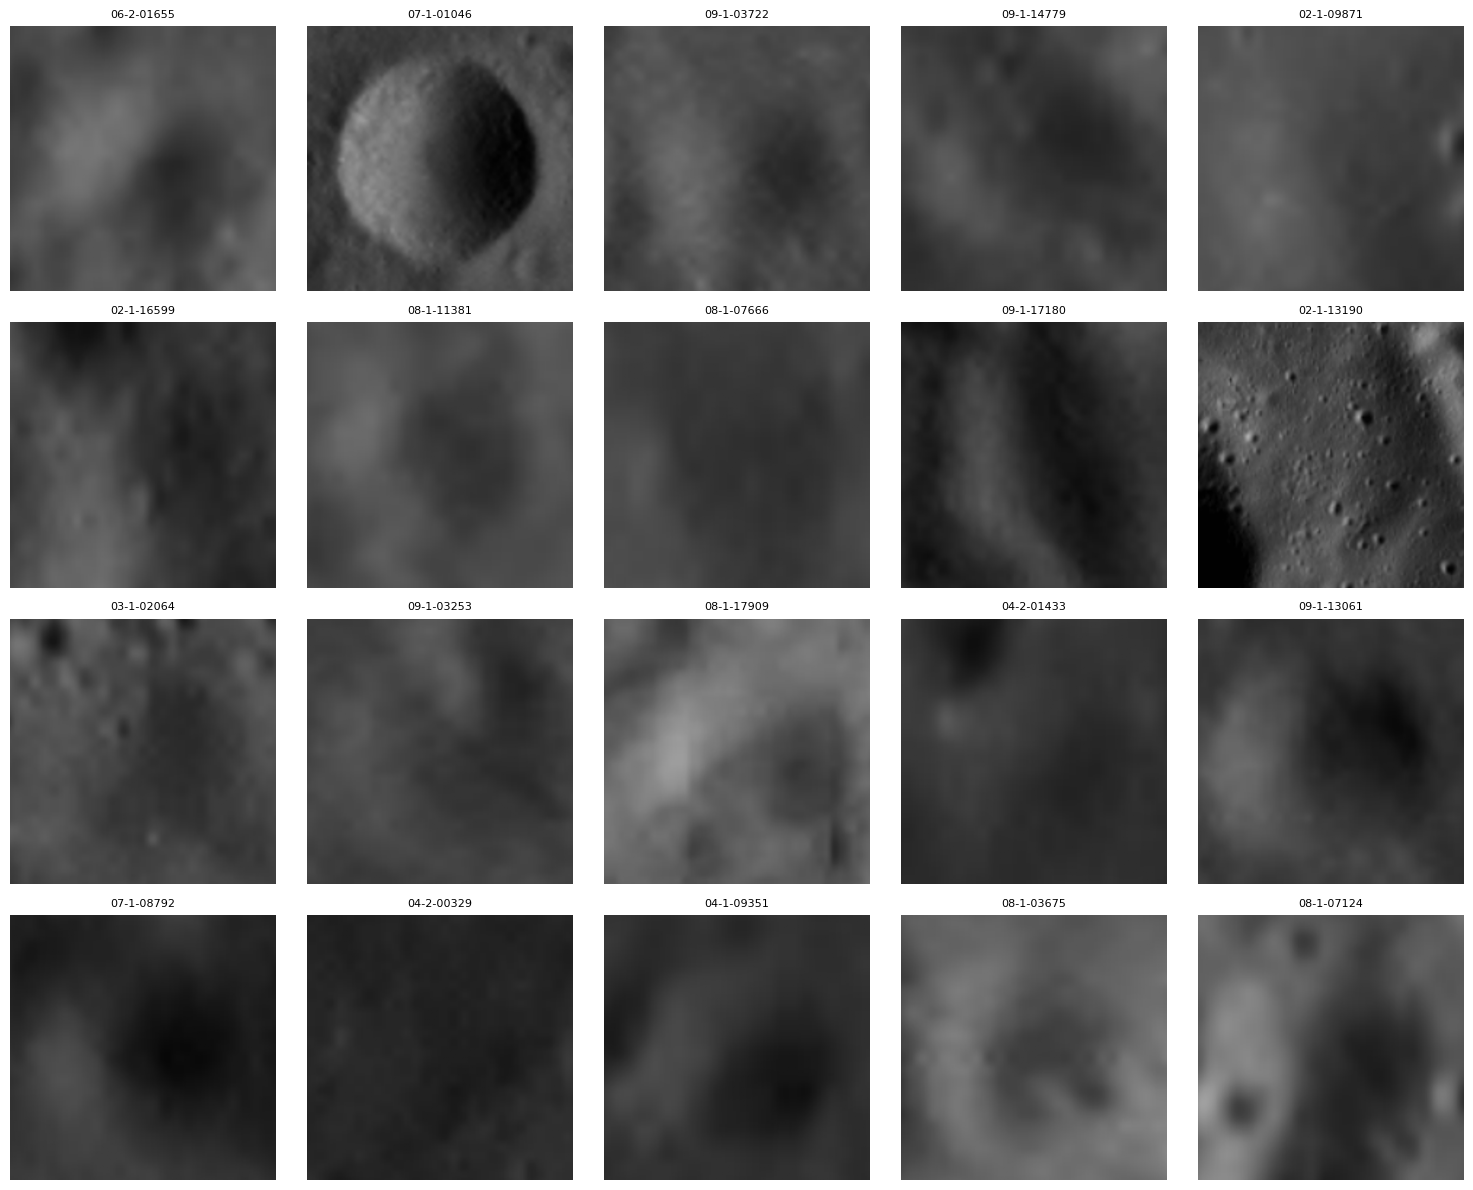


✅ PREPROCESSING TEST COMPLETE


In [10]:

# Test MAE crops (RGB)
quick_test_preprocessing('data/processed/mae/crater_crops', 'mae_craters_stats.npz', num_samples=20)

CLUSTERING EVALUATION ON HELD-OUT TEST SET
[PCA] Total variance explained (PC1+PC2): 30.61%
Saved plots to logs/cae/1.0_10.0_50_40/results

STANDARD CLUSTERING METRICS
ARI: 0.106 | NMI: 0.167

CLUSTER GEOMETRY COMPARISON
Procrustes disparity: 0.1056
(Lower = more similar geometric arrangement, 0 = identical)

Inter-cluster distance correlation: 0.500 (p=0.6667)
(Measures if relative cluster spacing is preserved)

CLUSTER QUALITY METRICS
Homogeneity: 0.198
  → Each cluster contains only members of a single class
Completeness: 0.145
  → All members of a class are assigned to the same cluster
V-Measure: 0.167
  → Harmonic mean (balanced measure)

INTERNAL CLUSTER QUALITY (Silhouette Score)
Predicted clusters: 0.108
Ground truth labels: 0.111
Difference: 0.003

Interpretation:
  ✓ Similar internal structure (clusters are comparably separated)

Per-cluster average silhouette:
Predicted clusters:
  Cluster 0: 0.089
  Cluster 1: 0.085
  Cluster 2: 0.154
Ground truth labels:
  Semi New Crater:

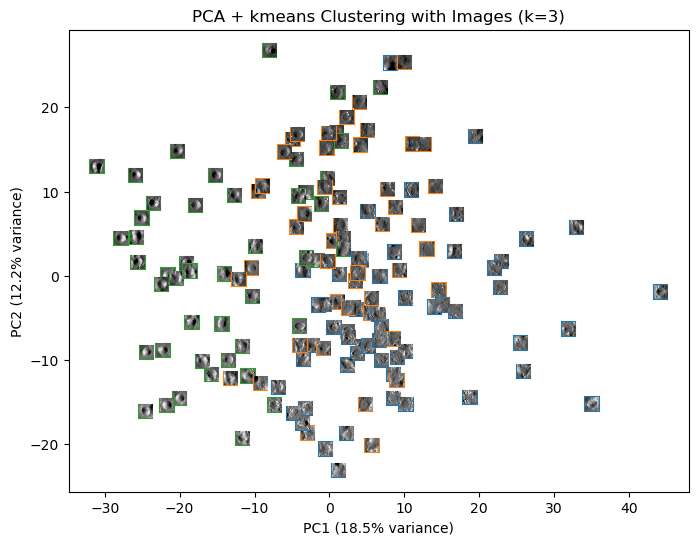

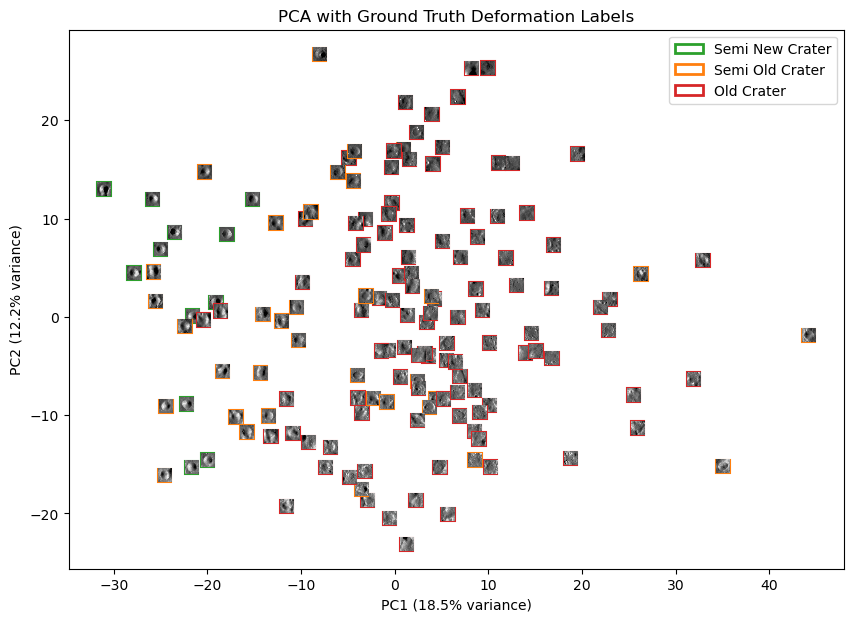

In [12]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='pca',           # Visualization technique
    cluster_method='kmeans',    # Clustering method
    n_clusters=3,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/cae/1.0_10.0_50_40/results"
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

CLUSTERING EVALUATION ON HELD-OUT TEST SET
[PCA] Total variance explained (PC1+PC2): 58.76%
Saved plots to logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/

STANDARD CLUSTERING METRICS
ARI: 0.033 | NMI: 0.106

CLUSTER GEOMETRY COMPARISON
Procrustes disparity: 0.4939
(Lower = more similar geometric arrangement, 0 = identical)

Inter-cluster distance correlation: -1.000 (p=0.0000)
(Measures if relative cluster spacing is preserved)

CLUSTER QUALITY METRICS
Homogeneity: 0.126
  → Each cluster contains only members of a single class
Completeness: 0.092
  → All members of a class are assigned to the same cluster
V-Measure: 0.106
  → Harmonic mean (balanced measure)

INTERNAL CLUSTER QUALITY (Silhouette Score)
Predicted clusters: 0.310
Ground truth labels: 0.015
Difference: 0.295

Interpretation:
  → Predicted clustering is better separated

Per-cluster average silhouette:
Predicted clusters:
  Cluster 0: 0.227
  Cluster 1: 0.326
  Cluster 2: 0.366
Grou

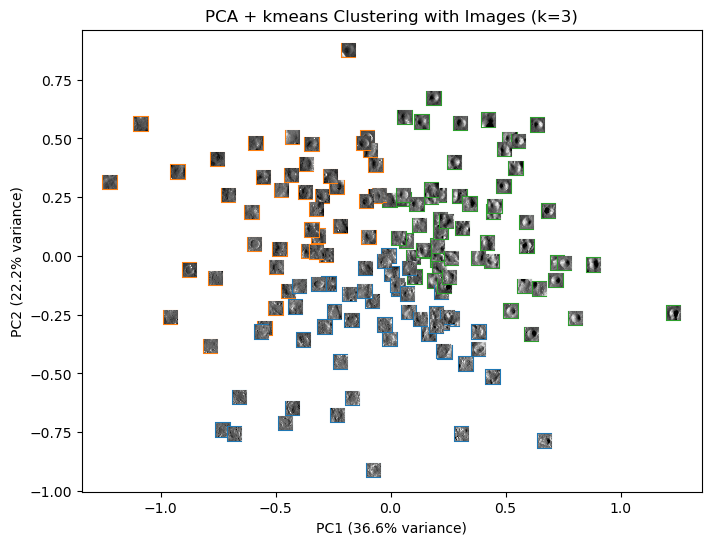

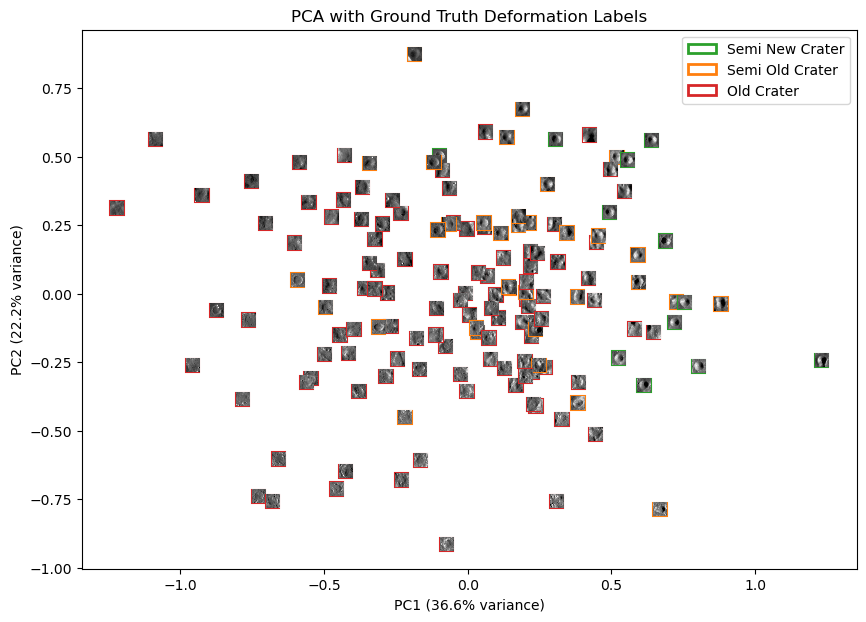

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='tsne',           # Visualization technique
    cluster_method='agg',    # Clustering method
    n_clusters=3,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/"
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

CLUSTERING EVALUATION ON HELD-OUT TEST SET
Saved plots to logs/cae/facebook/vit-mae-large/0_50_40/results

STANDARD CLUSTERING METRICS
ARI: 0.171 | NMI: 0.205

CLUSTER GEOMETRY COMPARISON
Procrustes disparity: 0.6640
(Lower = more similar geometric arrangement, 0 = identical)

Inter-cluster distance correlation: -1.000 (p=0.0000)
(Measures if relative cluster spacing is preserved)

CLUSTER QUALITY METRICS
Homogeneity: 0.233
  → Each cluster contains only members of a single class
Completeness: 0.184
  → All members of a class are assigned to the same cluster
V-Measure: 0.205
  → Harmonic mean (balanced measure)

INTERNAL CLUSTER QUALITY (Silhouette Score)
Predicted clusters: 0.243
Ground truth labels: 0.003
Difference: 0.241

Interpretation:
  → Predicted clustering is better separated

Per-cluster average silhouette:
Predicted clusters:
  Cluster 0: 0.081
  Cluster 1: 0.504
  Cluster 2: 0.361
Ground truth labels:
  Semi New Crater: 0.651
  Semi Old Crater: -0.311
  Old Crater: 0.034



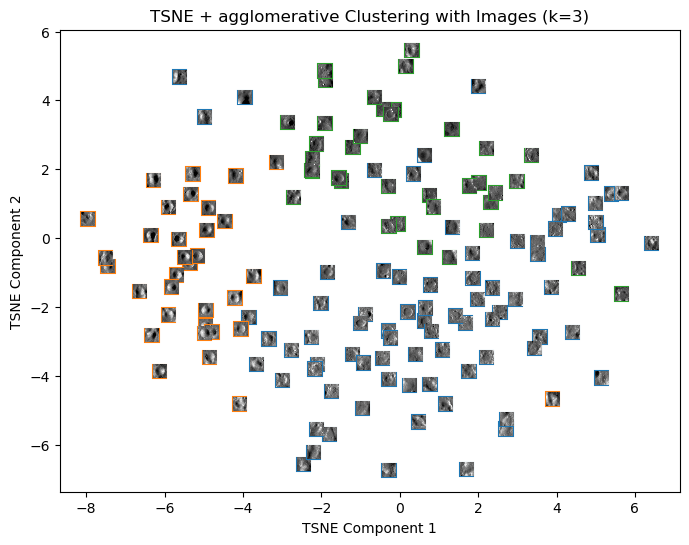

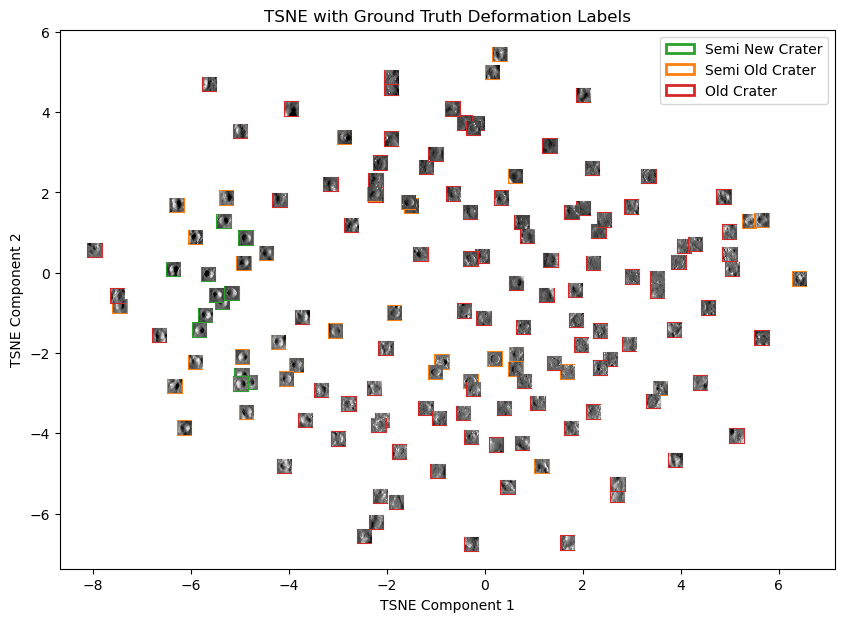

In [27]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='tsne',           # Visualization technique
    cluster_method='agglomerative',    # Clustering method
    n_clusters=3,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/cae/facebook/vit-mae-large/0_50_40/results"
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

/home/yardenk/autoencoder_project/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plots to logs/cae_latent40_l2_sched_pca/results/


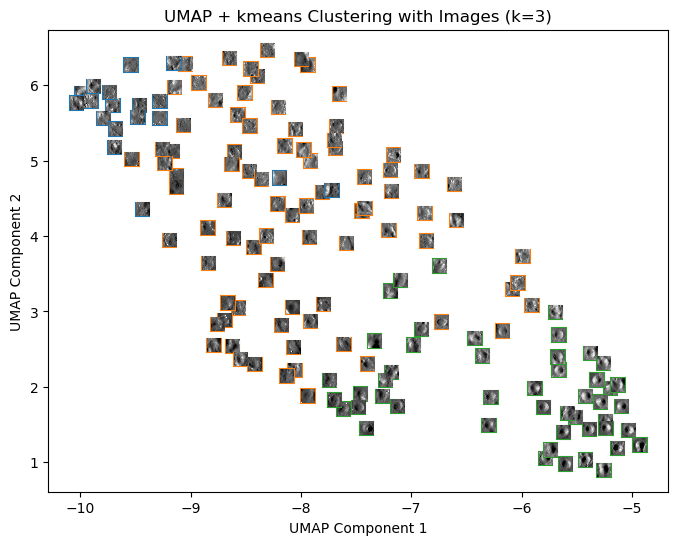

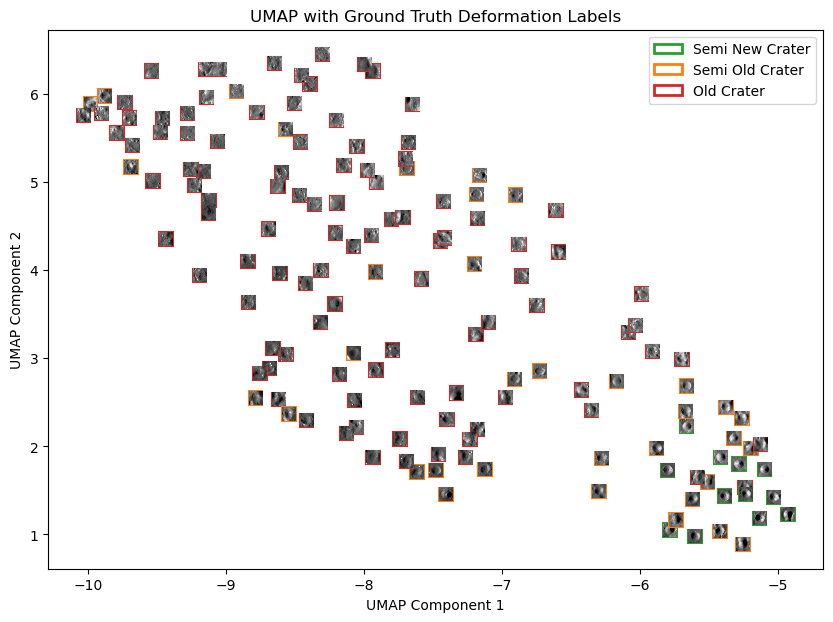

In [20]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_pca/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_pca/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/cae_latent40_l2_sched_pca/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

/home/yardenk/autoencoder_project/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plots to logs/cnn_latent40_l2_sched_500/results/new_validation/


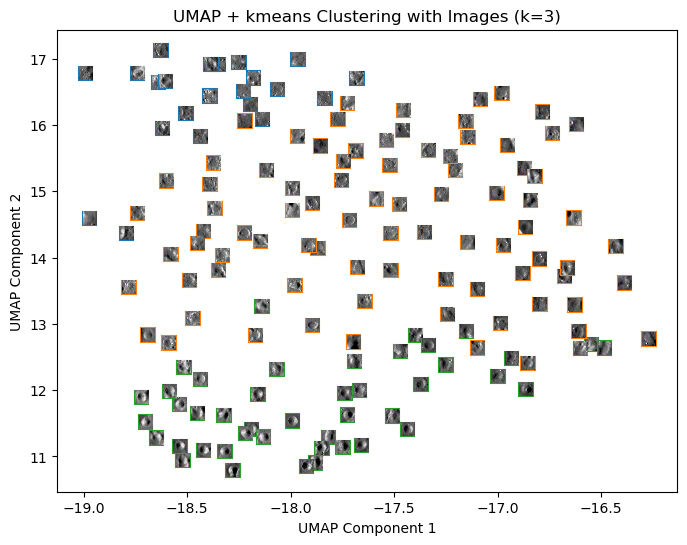

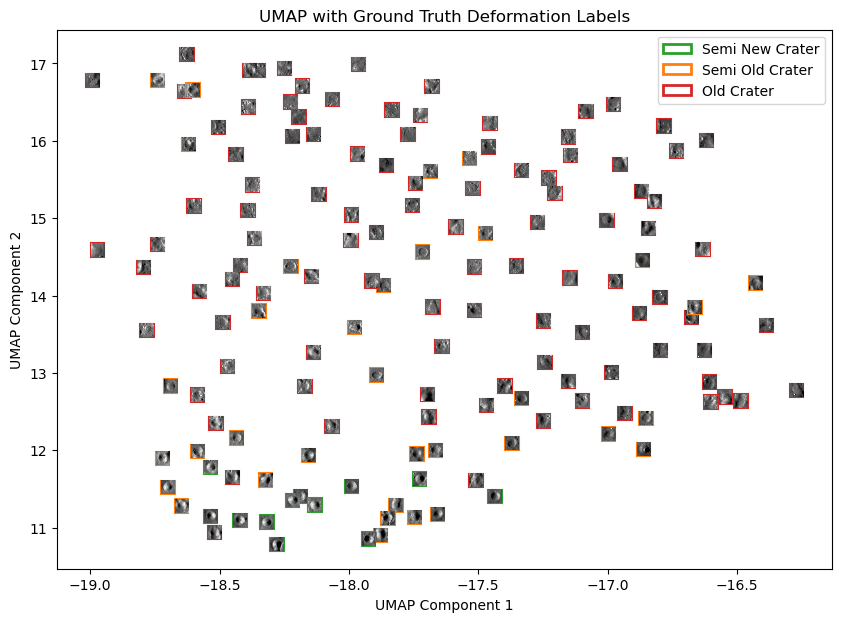

In [26]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_500/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_500/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/cnn_latent40_l2_sched_500/results/new_validation/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

/home/yardenk/autoencoder_project/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plots to logs/cnn_latent40_l2_sched_1_10/results/new_validation/


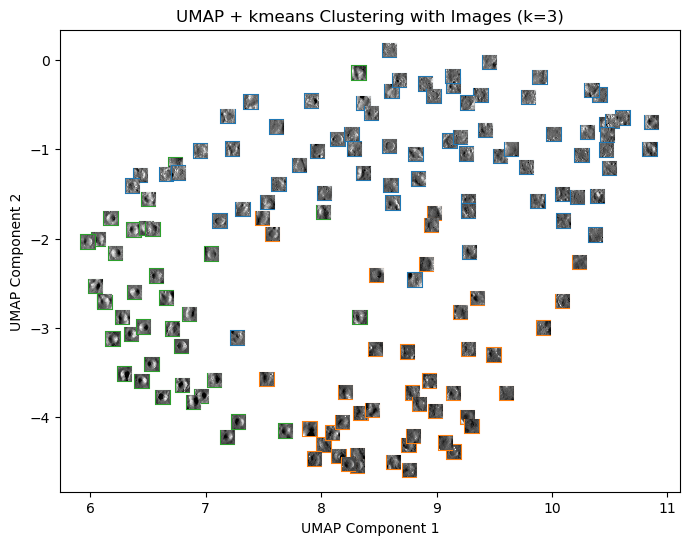

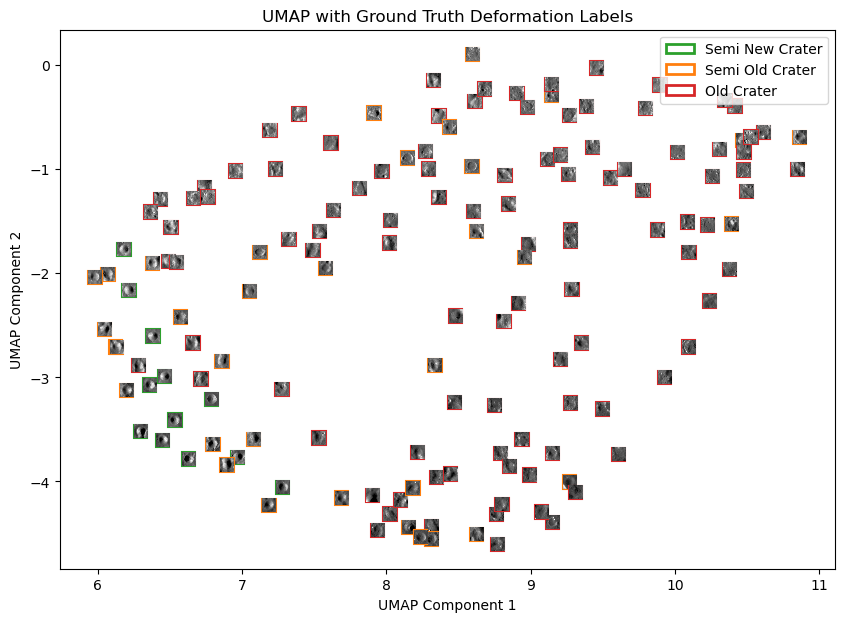

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_1_10/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_1_10/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/cnn_latent40_l2_sched_1_10/results/new_validation/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

[PCA] Total variance explained (PC1+PC2): 30.61%
Saved plots to logs/cae/facebook/vit-mae-large/0_50_40/results/


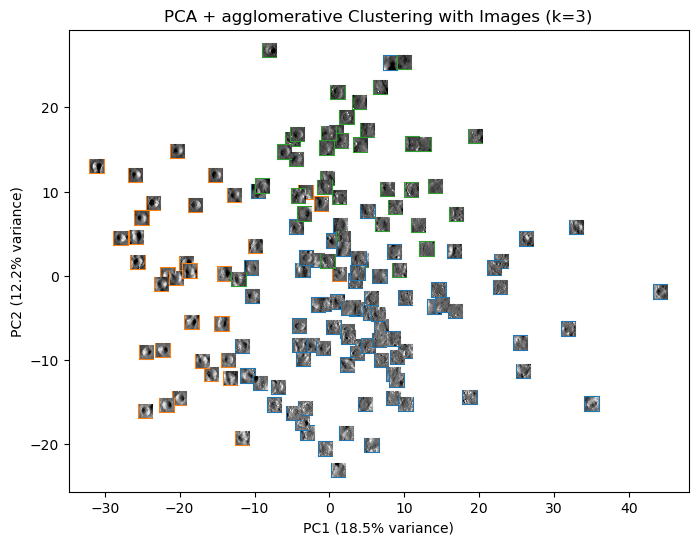

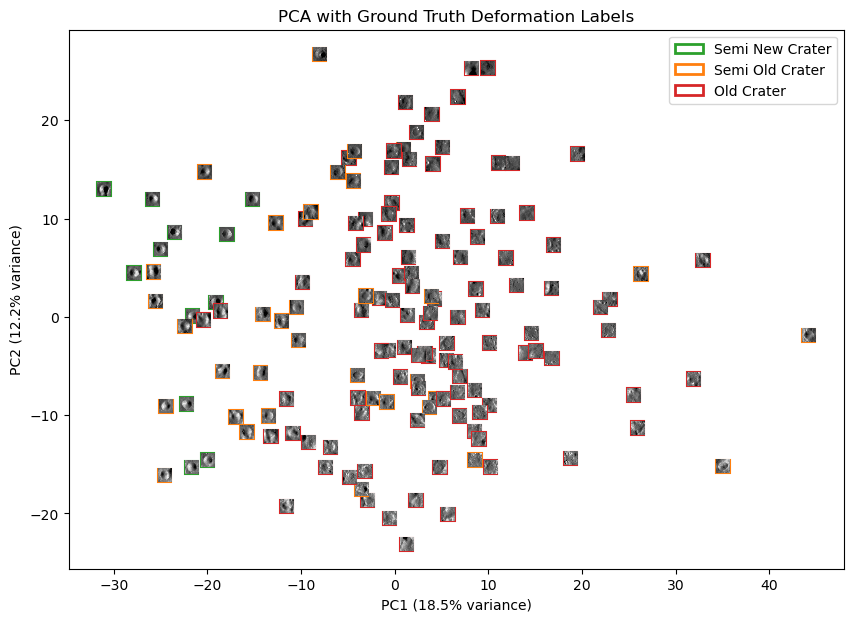

In [24]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_pca/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cae/facebook/vit-mae-large/0_50_40/results/latents.npy",
    technique='pca',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/cae/facebook/vit-mae-large/0_50_40/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/states_julie.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/latents_julie_with_flip.npy",
    technique='tsne',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cae_latent40_l2_sched_1_10/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cae_latent40_l2_sched_1_10/results/latents.npy",
    technique='tsne',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/cae_latent40_l2_sched_1_10/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
    )